# From Once upon a time, to Happily ever after
## A generative journey through Fairyland 

## System set up

In [1]:
import random

import ipywidgets as widgets
import spacy
import torch
from diffusers import StableDiffusionPipeline
from huggingface_hub import notebook_login
from IPython.display import HTML, display
from ipywidgets import fixed, interact_manual
from torch import autocast
from transformers import pipeline

In [2]:
!nvidia-smi

Wed Jan 25 10:17:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:0A:00.0 Off |                  N/A |
|  0%   25C    P8    10W / 280W |      8MiB / 11178MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:42:00.0 Off |                  N/A |
|  0%   

A [Hugging Face](https://huggingface.co/) account and token is required to use the [Stable Diffusion](https://huggingface.co/CompVis/stable-diffusion-v1-4) text-to-image generator.

In [4]:
notebook_login()

## Set up image generation

In [5]:
diffusion_device = 0
diffusion_model_path = "stabilityai/stable-diffusion-2"

try:
    del diffusion
except NameError:
    pass

diffusion = StableDiffusionPipeline.from_pretrained(
    diffusion_model_path, use_auth_token=True, revision="fp16", torch_dtype=torch.float16
)
diffusion = diffusion.to(diffusion_device)
print(
    f"Diffusion - device {diffusion_device} | {torch.cuda.memory_allocated(diffusion_device) / 1000000}MiB"
)

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

Diffusion - device 0 | 2600.654848MiB


In [6]:
def generate_image(prompt: str, num_images_per_prompt: int = 1, width: int = 768, height: int = 768, seed: int = 1024):
    images = diffusion(
        prompt,
        num_images_per_prompt=num_images_per_prompt,
        width=width,
        height=height,
        generator=torch.Generator("cuda").manual_seed(seed),
    )

    return images

  0%|          | 0/50 [00:00<?, ?it/s]

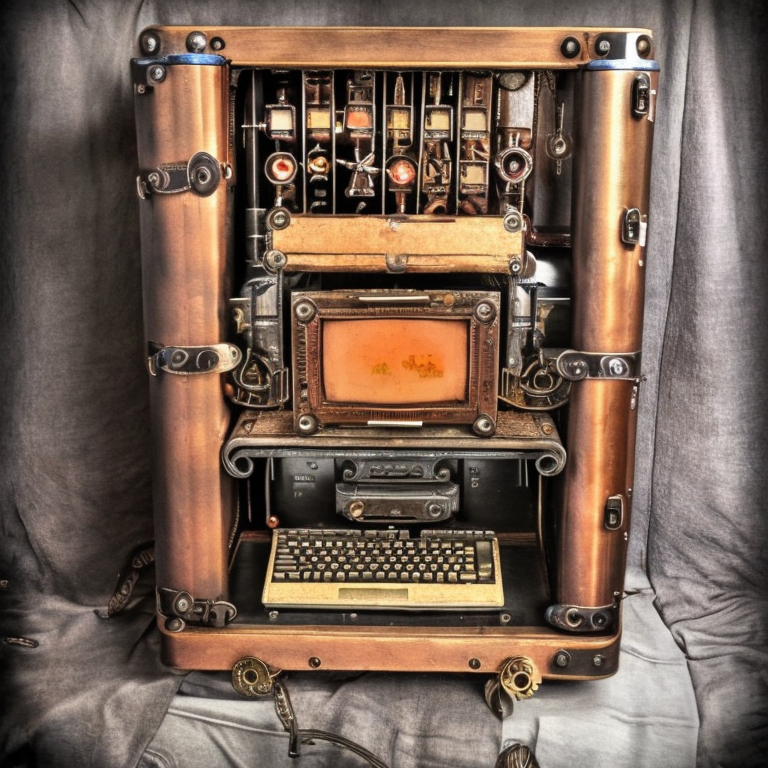

In [7]:
images = generate_image("a photo of steampunk computer", seed=random.randint(0, 100))
for image in images.images:
    display(image)

## Set up text generation

In [8]:
gpt_device = 1
gpt_model_path = "../data/final/grimm_4_1.3B/"

try:
    del gpt
except NameError:
    pass

gpt = pipeline("text-generation", model=gpt_model_path, device=gpt_device)
print(
    f"GPT - device {gpt_device} | {torch.cuda.memory_allocated(gpt_device) / 1000000}MiB"
)

GPT - device 1 | 5362.978816MiB


### Set up text summarisation

Summarisation is used to convert text into image generation prompts.

In [9]:
summariser_model_path = "facebook/bart-large-cnn"

try:
    del summariser
except NameError:
    pass

summariser = pipeline("summarization", model=summariser_model_path, device=gpt_device)
print(
    f"Summariser - device {gpt_device} | {torch.cuda.memory_allocated(gpt_device) / 1000000}MiB"
)

Summariser - device 1 | 6988.34176MiB


In [10]:
def summarise(text: str, min_length: int = 10, max_length: int = 50) -> str:
    if len(text.split()) < max_length:
        return text

    output = summariser(text, min_length=10, max_length=50)
    return output[0]["summary_text"].strip()

## Generation

### Text generation

In [14]:
text_form = widgets.Output(layout=dict(border="1px solid black", padding="5px"))

text_widget = widgets.Textarea(
    description="Text",
    placeholder="Type a prompt to generate text from",
    layout=dict(width="auto", height="500px"),
)
max_length_widget = widgets.IntText(
    value=250,
    description="Max length",
    tooltip="Maximum number of tokens",
)
temperature_widget = widgets.FloatSlider(
    value=0.5,
    min=0.0,
    max=1.0,
    description="Temperature",
    tooltip="How sensitive the algorithm is to selecting low probability options",
)
top_k_widget = widgets.IntText(
    value=50,
    description="Top k",
    tooltip="How many potential answers are considered when performing sampling",
)
top_p_widget = widgets.FloatText(
    value=1.0,
    min=0.0,
    max=1.0,
    description="Top p",
    tooltip="Min number of tokens are selected where their probabilities add up to top_p",
)
no_repeat_ngram_size_widget = widgets.IntText(
    value=0,
    description="No repeat ngrams",
    tooltip="The size of an n-gram that cannot occur more than once. (0=infinity)",
)

In [15]:
def generate_text(
    prompt: str,
    max_length: int = 200,
    temperature: float = 0.5,
    top_k: int = 50,
    top_p: float = 1.0,
    no_repeat_ngram_size: int = 0,
) -> str:
    output = gpt(
        prompt,
        max_length=len(prompt) + max_length,
        temperature=temperature,
        top_k=top_k,
        top_p=top_p,
        no_repeat_ngram_size=no_repeat_ngram_size,
    )
    generated_text = output[0]["generated_text"]

    with text_widget.hold_trait_notifications():
        text_widget.value = generated_text


with text_form:
    interact_manual(
        generate_text,
        prompt=text_widget,
        max_length=max_length_widget,
        temperature=temperature_widget,
        top_k=top_k_widget,
        top_p=top_p_widget,
        no_repeat_ngram_size=no_repeat_ngram_size_widget,
    )

display(text_form)

Output(layout=Layout(border_bottom='1px solid black', border_left='1px solid black', border_right='1px solid b…

### Image generation

An image is generated for each paragraph in the generated text. If the generated text doesn't have any paragraphs, edit the text in the textarea above and add new lines before running the image generation.

**Need to find a better summariser!**

In [17]:
prompts = []

paragraphs = text_widget.value.split("\n")
for p in paragraphs:
    if p:
        summary = summarise(p)
        prompts.append(summary)


def generate_story(text: str, style: str, seed: int):
    prompts = text.split("\n")

    for idx, prompt in enumerate(prompts):
        seed += idx
        if prompt:
            prompt = f"{prompt} {style}"
            image = generate_image(prompt, seed=seed)[0][0]

            tag = "p"
            display(HTML(f"<{tag}>{paragraphs[idx]}</{tag}>"))
            display(image)
            display(
                HTML(
                    f"<small style='font-size: 8px'>prompt: {prompt}, seed: {seed}</small>"
                )
            )


image_form = widgets.Output(layout=dict(border="1px solid black", padding="5px"))

image_prompt_widget = widgets.Textarea(
    description="Image prompts",
    value="\n\n".join(prompts),
    placeholder="Image prompts, one per line",
    layout=dict(width="auto", height="200px"),
)
image_style_widget = widgets.Text(description="Image style", value="")
image_seed_widget = widgets.IntText(description="Seed", value=random.randint(0, 2048))

with image_form:
    interact_manual(
        generate_story,
        text=image_prompt_widget,
        style=image_style_widget,
        seed=image_seed_widget,
    )

display(image_form)

Output(layout=Layout(border_bottom='1px solid black', border_left='1px solid black', border_right='1px solid b…